<a href="https://colab.research.google.com/github/HannahLange/Active-Learning/blob/main/ContinuousFH_Bloch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install 'git+https://github.com/netket/netket.git#egg=netket'

  Cloning https://github.com/netket/netket.git to /tmp/pip-install-3nu3gcdh/netket_8adc300f1dca4eb0a999d665596a0d76
  Running command git clone --filter=blob:none --quiet https://github.com/netket/netket.git /tmp/pip-install-3nu3gcdh/netket_8adc300f1dca4eb0a999d665596a0d76
  Resolved https://github.com/netket/netket.git to commit 6db0f51f9df2f750ae1ff1d54f366eff07501efd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 4.5 MB/s eta 0:00:00
  Created wheel for n

In [2]:
import jax
import jax.numpy as jnp
import netket as nk
import netket.experimental as nkx
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

DTYPE = jnp.float64
DTYPE

jax.numpy.float64

In [3]:
import jax
import jax.numpy as jnp
import numpy as np

import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np

from netket.utils import struct
import netket as nk
from functools import partial

from typing import Optional, Any
from netket.sampler import MetropolisSampler, MetropolisRule
import netket.jax as nkjax

from netket.experimental.hilbert import ContinuousHilbert

import jax
import jax.numpy as jnp
import numpy as np

class GaussianNNHopRule(MetropolisRule):
    r"""
    A transition rule that uses Langevin dynamics [1] to update samples.

    .. math::
       x_{t+dt} = x_t + dt \nabla_x \log p(x) \vert_{x=x_t} + \sqrt{2 dt}\eta,

    where  :math:`\eta` is normal distributed noise :math:`\eta \sim \mathcal{N}(0,1)`.
    This rule only works for continuous Hilbert spaces.
    [1]: https://en.wikipedia.org/wiki/Metropolis-adjusted_Langevin_algorithm
    """

    initial_dt: float
    """
    Time step in the Langevin dynamics
    """
    chunk_size: int = struct.field(pytree_node=False, default=None)
    """
    Chunk size for computing gradients of the ansatz
    """

    def __init__(self, initial_dt: float = 1e-3):
        self.initial_dt = initial_dt

    def init_state(
        self,
        sampler: "sampler.MetropolisSampler",  # noqa: F821
        machine: nn.Module,
        params,
        key,
    ) -> Optional[Any]:
        dt = self.initial_dt
        return dt

    def transition(rule, sampler, machine, parameters, state, key, r):
        if jnp.issubdtype(r.dtype, jnp.complexfloating):
            raise TypeError("LangevinRule does not work with complex basis elements.")

        n_chains = r.shape[0]
        hilb = sampler.hilbert

        pbc = np.array(hilb.n_particles * hilb.geometry.pbc, dtype=r.dtype)
        boundary = np.tile(pbc, (n_chains, 1))

        Ls = np.array(hilb.n_particles * hilb.geometry.extent, dtype=r.dtype)
        modulus = np.where(np.equal(pbc, False), jnp.inf, Ls)

        # one langevin step
        dt = state.rule_state
        rp, log_corr = discrete_langevin_step(
            key,
            r,
            machine.apply,
            parameters,
            sampler.machine_pow,
            dt,
            chunk_size=rule.chunk_size,
            return_log_corr=True,
        )

        rp = jnp.where(np.equal(boundary, False), rp, rp % modulus)

        return rp, log_corr

    def __repr__(self):
        return f"LangevinRule()"


from functools import partial
import jax
import jax.numpy as jnp
from jax import random

@partial(jax.jit, static_argnames=("apply_fun", "chunk_size", "return_log_corr"))
def discrete_langevin_step(
    key,
    r,
    apply_fun,
    parameters,
    machine_pow,
    dt,
    chunk_size=None,
    return_log_corr=True,
):
    """Single MALA-style step with discrete ±1 shift and Gaussian noise"""
    n_chains, hilb_size = r.shape
    key_delta, key_noise = jax.random.split(key)

    # Discrete shift: δ_i ∈ {-1, 0, +1}
    delta = jax.random.choice(key_delta, jnp.array([-1, 0, 1]), shape=r.shape)

    # Continuous Gaussian noise
    noise_vec = jax.random.normal(key_noise, shape=r.shape, dtype=r.dtype)

    # Proposal: x' = x + δ + sqrt(2*dt)*noise
    rp = r + delta + jnp.sqrt(2 * dt) * noise_vec

    def _log_prob(x):
        return machine_pow * apply_fun(parameters, x).real

    def _single_grad(x):
        x = x.reshape(x.shape[-1])
        g = jax.grad(lambda xi: _log_prob(xi).ravel()[0])(x)
        return g.real if not jnp.iscomplexobj(r) else g

    # Optional MH correction
    if not return_log_corr:
        return rp

    else:
      # Log proposal densities
      # q(x' | x) = N(x'; x + δ, 2dt I)
      # q(x | x') = N(x; x' - δ, 2dt I)
      diff_fwd = rp - (r + delta)
      #key_delta, key_noise = jax.random.split(key)
      # Discrete shift: δ_i ∈ {-1, 0, +1}
      #delta = jax.random.choice(key_delta, jnp.array([-1, 0, 1]), shape=r.shape)
      diff_bwd = r - (rp - delta)

      log_q_forward = -jnp.sum(diff_fwd ** 2, axis=-1) / (4 * dt)  #-0.5 * jnp.sum(noise_vec**2, axis=-1) #
      log_q_backward = -jnp.sum(diff_bwd ** 2, axis=-1) / (4 * dt)

      return rp, log_q_backward - log_q_forward



class MetropolisGaussianNNHopAdaptive(MetropolisSampler):
    target_acceptance: float
    dt_limits: Any = None

    def __init__(self, hilbert, initial_dt=1.0, dt_limits=None, target_acceptance=0.65, **kwargs):
        rule = GaussianNNHopRule(initial_dt=initial_dt)
        super().__init__(hilbert, rule, **kwargs)
        if dt_limits is None:
            dt_limits = [initial_dt*1e-2, initial_dt*1e2]
        self.dt_limits = tuple(dt_limits)
        self.target_acceptance = target_acceptance

    def _sample_next(self, machine, parameters, state):
        new_state, new_σ = super()._sample_next(machine, parameters, state)

        if self.target_acceptance is not None:
            acceptance = new_state.n_accepted / new_state.n_steps
            dt = new_state.rule_state
            new_dt = dt / (self.target_acceptance / jnp.max(jnp.stack([acceptance, jnp.array(0.05)])))
            new_dt = jnp.max(jnp.array([new_dt, self.dt_limits[0]]))
            new_dt = jnp.min(jnp.array([new_dt, self.dt_limits[1]]))
            new_rule_state = new_dt
            new_state = new_state.replace(
                rule_state=new_rule_state
            )

        return new_state, new_σ

Exact diagonalization for the single-particle problem

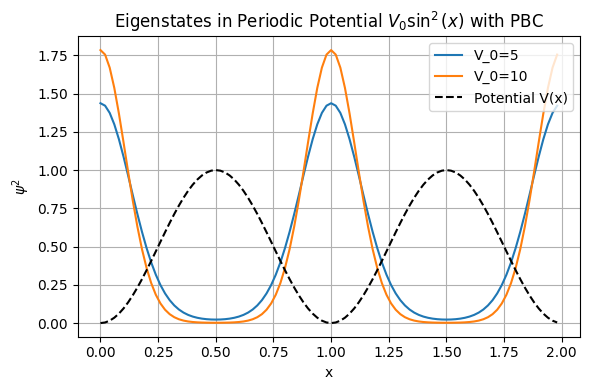

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import eigsh
from jax.experimental import sparse

def diagonalize_Ham(L, V0, x, m=1*np.pi**2, num_states = 1):
  x = np.array(x)
  Ngrid = x.shape[0]
  dx = x[1] - x[0]

  # --- Potential: V(x) = V0 * sin^2(x) ---
  V = V0 * np.sin(np.pi*x)**2

  # --- Kinetic Energy Matrix with Periodic BC ---
  diagonals = [
      np.full(Ngrid, -2.0),           # main diagonal
      np.full(Ngrid - 1, 1.0),        # upper diagonal
      np.full(Ngrid - 1, 1.0)         # lower diagonal
  ]
  offsets = [0, 1, -1]
  T = diags(diagonals, offsets, shape=(Ngrid, Ngrid), format='lil')

  # Periodic boundary conditions:
  T[0, -1] = T[-1, 0] = 1.0

  # Convert to sparse CSR format for efficiency
  T = T.tocsr()
  T *= - 1 / (2 * m * dx**2)

  # --- Potential Energy Matrix ---
  V_matrix = diags(V, 0)

  # --- Total Hamiltonian ---
  H = T + V_matrix

  # --- Solve Eigenvalue Problem ---
  eigenvalues, eigenvectors = eigsh(H, k=num_states, which='SM')
  return  eigenvalues, eigenvectors


def build_kinetic_dense(Ngrid):
    main_diag = -2.0 * jnp.ones(Ngrid)
    upper_diag = jnp.ones(Ngrid - 1)
    lower_diag = jnp.ones(Ngrid - 1)

    T = jnp.diag(main_diag)
    T += jnp.diag(upper_diag, k=1)
    T += jnp.diag(lower_diag, k=-1)

    # Apply periodic boundary conditions:
    T = T.at[0, -1].set(1.0)
    T = T.at[-1, 0].set(1.0)

    return T

def diagonalize_Ham_jax(L, V0, x, m=1*np.pi**2, num_states = 1):
  Ngrid = x.shape[0]
  dx = x[1] - x[0]

  # --- Potential: V(x) = V0 * sin^2(x) ---
  V = V0 * jnp.sin(np.pi*x)**2

  # --- Kinetic Energy Matrix with Periodic BC ---
  diagonals = [
      jnp.full(Ngrid, -2.0),           # main diagonal
      jnp.full(Ngrid - 1, 1.0),        # upper diagonal
      jnp.full(Ngrid - 1, 1.0)         # lower diagonal
  ]

  T = build_kinetic_dense(Ngrid)
  T *= - 1 / (2 * m * dx**2)


  # --- Potential Energy Matrix ---
  V_matrix = jnp.diag(V, k=0)

  # --- Total Hamiltonian ---
  H = T + V_matrix

  # --- Solve Eigenvalue Problem ---
  eigenvalues, eigenvectors = jnp.linalg.eigh(H)
  return  eigenvalues[:num_states], eigenvectors[:,:num_states]




Ngrid = 100       # Number of grid points
L = 2
plt.figure(figsize=(6, 4))
x = np.linspace(0, L, Ngrid, endpoint=False)  # periodic: exclude endpoint
dx = x[1] - x[0]
for v0 in [5,10]:
  eigenvalues, eigenvectors = diagonalize_Ham_jax(L, v0, x)
  # --- Plotting ---
  for i in range(eigenvalues.shape[0]):
      psi = eigenvectors[:, i]
      psi /= np.sqrt(np.sum(np.abs(psi)**2) * dx)  # normalize
      plt.plot(x, psi**2, label=f"V_0={v0}")
      break

plt.plot(x, np.sin(np.pi*x)**2, 'k--', label='Potential V(x)')
plt.title("Eigenstates in Periodic Potential $V_0 \\sin^2(x)$ with PBC")
plt.xlabel("x")
plt.ylabel(r"$\psi^2$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Define the model

In [19]:
"""import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
from netket.experimental.hilbert import ContinuousHilbert
from netket.utils.types import NNInitFunc, DType
import netket as nk

class ExactSlater(nn.Module):
    hilbert: ContinuousHilbert
    V0: float
    coeff_init: NNInitFunc = jax.nn.initializers.normal(stddev=1e-1)
    param_dtype: DType = jnp.float32

    @nn.compact
    def __call__(self, x):
        n_particles = self.hilbert.n_particles
        n_per_spin = self.hilbert.n_per_spin
        n_max = max(n_per_spin)
        sdim = len(self.hilbert.domain)
        x = x.reshape(-1, n_particles)
        batch_size = x.shape[0]
        extent = self.hilbert.geometry.extent

        coeffs1 = self.param("cs1", self.coeff_init, (1,), self.param_dtype)



        _, orbs = diagonalize_Ham_jax(extent[0], self.V0, x, num_states=n_max)
        assert orbs.shape == (batch_size, n_particles, n_max)

        # UHF factorized the determinant in up and down components
        # det = det up x det dn
        log_psi = 0

        orbs_per_spin = jnp.split(orbs, np.cumsum(n_per_spin)[:-1], axis=1) # split in particles with different spins
        for orbs_spin in orbs_per_spin:
            nf = orbs_spin.shape[1]
            if nf == 0:
                continue
            # first select the number of orbitals for this spin (filling up orbitals)
            orbs_spin = orbs_spin[..., :nf]
            assert orbs_spin.shape == (batch_size, nf, nf)
            # multiply the different spin determinants
            jax.debug.print("orbs spin {s}",s=orbs_spin.shape)
            sign, lp = jnp.linalg.slogdet(orbs_spin)
            log_psi += lp + jnp.log(sign+0j)
        return log_psi


# test exact ansatz
geom = nkx.geometry.Cell(1, L=L, pbc=True)
hi = nkx.hilbert.Particle(N=(1,0), geometry=geom)
model = ExactSlater(hi, 5)
nbins = 200

sa = MetropolisGaussianNNHopAdaptive(hi, initial_dt=0.05, n_chains=64, sweep_size=max(16, 3*hi.size))
vs = nk.vqs.MCState(sa, model, n_samples=1024, n_discard_per_chain=16)
opt = nk.optimizer.Sgd(0.01)
gs = nk.VMC(ham, opt, variational_state=vs)
gs.run(n_iter=1)
for i in range(10):
  sam = vs.sample()

samples = sam.reshape(-1)
density, bin_edges = np.histogram(samples, bins=nbins//2, range=(0, L))
x = (bin_edges[1:] + bin_edges[:-1])/2
print((density/samples.shape[0]*N).sum())
plt.plot(x,density/samples.shape[0]*N)
plt.ylabel("density $n(x)$")
plt.xlabel("$x$")
plt.show()
"""


'import numpy as np\nimport jax\nimport jax.numpy as jnp\nimport flax.linen as nn\nfrom netket.experimental.hilbert import ContinuousHilbert\nfrom netket.utils.types import NNInitFunc, DType\nimport netket as nk\n\nclass ExactSlater(nn.Module):\n    hilbert: ContinuousHilbert\n    V0: float \n    coeff_init: NNInitFunc = jax.nn.initializers.normal(stddev=1e-1)\n    param_dtype: DType = jnp.float32\n\n    @nn.compact\n    def __call__(self, x):\n        n_particles = self.hilbert.n_particles\n        n_per_spin = self.hilbert.n_per_spin\n        n_max = max(n_per_spin)\n        sdim = len(self.hilbert.domain)\n        x = x.reshape(-1, n_particles)\n        batch_size = x.shape[0]\n        extent = self.hilbert.geometry.extent\n\n        coeffs1 = self.param("cs1", self.coeff_init, (1,), self.param_dtype)\n        \n\n\n        _, orbs = diagonalize_Ham_jax(extent[0], self.V0, x, num_states=n_max)\n        assert orbs.shape == (batch_size, n_particles, n_max) \n\n        # UHF factorize

For the basis function \texttt{wannier\_basis\_fn} (below) I use two types of Fourier modes are used:

\begin{align*}
\tilde{x} &= \frac{2\pi}{L} x, \quad \text{( periodic w.r.t. L)} \\
\hat{x} &= \pi/a x, \quad \text{(periodic w.r.t. potential a)} \\
\text{Basis components:} \quad
f_L(x) &= \left[ \cos(m \tilde{x}), \sin(m \tilde{x}) \right]_{m=0}^{m_{\text{max}}^L}, \\
f_a(x) &= \left[ \cos(m \hat{x}), \sin(m \hat{x}) \right]_{m=0}^{m_{\text{max}}^a}.
\end{align*}

These form the input features for the Slater determinant construction.



The model constructs single-particle orbitals as linear combinations of these basis functions:
\begin{align}
\psi_a(x) &= \sum C^a_i f_a(x)\\
\psi_L(x) &= \sum C^L_i f_L(x)
\end{align}
and multiplies them. Thats not exactly a Bloch wave function but $\psi_a(x)$ is similar to $u(r)$ in the Bloch wave functions.

In [107]:
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
from netket.experimental.hilbert import ContinuousHilbert
from netket.utils.types import NNInitFunc, DType
import netket as nk

# definition of the simplest model with Wannier orbitals
def wannier_basis_fn(x, *, extent, m_max_L, m_max_a):
    # input: x = (..., sdim)
    # output: out = (..., m_max)
    # and in our case: x \in [0, L] (not [-L, L])
    scaled_x = 2*jnp.pi / jnp.asarray(extent) * x
    ms_L = jnp.arange(m_max_L+1)
    ms_a = jnp.arange(m_max_a+1)
    cos_L = jnp.cos(ms_L*scaled_x)
    sin_L = jnp.sin(ms_L*scaled_x)
    scaled_x = jnp.pi * x
    cos_a = jnp.cos(ms_a*scaled_x)
    sin_a = jnp.sin(ms_a*scaled_x)
    fm1 = jnp.stack([cos_L, sin_L], axis=-1)
    fm2 = jnp.stack([cos_a, sin_a], axis=-1)
    return fm1.reshape(*x.shape[:-1], 2*(m_max_L+1)), fm2.reshape(*x.shape[:-1], 2*(m_max_a+1))

def normal_eye_init(stddev=1e-2):
    """ Initialize 2D matrices with an np.eye with noise on top """
    def _normal_eye_init(key, shape, dtype):
        assert len(shape) == 2
        eye = jnp.eye(shape[0], M=shape[1], dtype=dtype)
        noise = jax.random.normal(key, shape, dtype)
        return eye + noise
    return _normal_eye_init

class WannierSlater(nn.Module):
    """ Restricted Hartree-Fock type slater in the Wannier basis. """
    hilbert: ContinuousHilbert
    m_wann_max_L: int
    m_wann_max_a: int
    coeff_init: NNInitFunc = jax.nn.initializers.normal(stddev=1e-1)
    param_dtype: DType = jnp.float32

    @nn.compact
    def __call__(self, x):
        n_particles = self.hilbert.n_particles
        n_per_spin = self.hilbert.n_per_spin
        n_max = max(n_per_spin)
        sdim = len(self.hilbert.domain)
        x = x.reshape(-1, n_particles, sdim)
        batch_size = x.shape[0]
        extent = self.hilbert.geometry.extent

        # compute the basis
        fm_x1, fm_x2 = wannier_basis_fn(x, extent=extent, m_max_L=self.m_wann_max_L, m_max_a=self.m_wann_max_a)

        coeffs1 = self.param("cs1", self.coeff_init, (n_max, fm_x1.shape[-1]), self.param_dtype)
        coeffs2 = self.param("cs2", self.coeff_init, (n_max, fm_x2.shape[-1]), self.param_dtype)

        # Define orbitals as a product of L and a terms
        orbs = (fm_x1 @ coeffs1.T) * (fm_x2 @ coeffs2.T) # shape = [*, nf, nf]
        assert orbs.shape == (batch_size, n_particles, n_max) # the last axis is the orbital axis

        # UHF factorized the determinant in up and down components
        # det = det up x det dn
        log_psi = 0
        orbs_per_spin = jnp.split(orbs, np.cumsum(n_per_spin)[:-1], axis=1) # split in particles with different spins
        for orbs_spin in orbs_per_spin:
            nf = orbs_spin.shape[1]
            if nf == 0:
                continue
            # first select the number of orbitals for this spin (filling up orbitals)
            orbs_spin = orbs_spin[..., :nf]
            assert orbs_spin.shape == (batch_size, nf, nf)
            # multiply the different spin determinants
            log_psi += nk.jax.logdet_cmplx(orbs_spin)
        return log_psi



In [108]:
sdim = 1
L = 2
n_per_spin = (1,0)
lattice_spacing = 1.
M = 1.
V0 = 5.
nsamples = 1024

geom = nkx.geometry.Cell(sdim, L=L, pbc=True)
hi = nkx.hilbert.Particle(N=n_per_spin, geometry=geom)
# NOTE: hi.geometry.distance is the minimal image distance between particles

def pot_fn_single_particle(x):
    assert x.shape == (sdim,)
    scaled_x = jnp.pi * x #+ np.pi/2
    out = V0*jnp.sin(scaled_x)**2
    return out

def pot_fn(x):
    # let's take a periodic potential
    x = x.reshape(hi.n_particles, sdim)
    y = jax.vmap(pot_fn_single_particle)(x)
    return jnp.sum(y) # sum over d and N

epot = nk.operator.PotentialEnergy(hi, pot_fn)
ekin = nk.operator.KineticEnergy(hi, mass=M*(lattice_spacing**2)*np.pi**2)
ham = ekin + epot



In [116]:

m_max_L = 2
m_max_a = 10
model = WannierSlater(
    hi,
    m_wann_max_L=m_max_L,
    m_wann_max_a=m_max_a,
    param_dtype=DTYPE,
)
print(model)
#sigma=sqrt(2*dt)
sa = MetropolisGaussianNNHopAdaptive(hi, initial_dt=0.05, n_chains=64, sweep_size=max(16, 3*hi.size))

vs = nk.vqs.MCState(sa, model, n_samples=nsamples, n_discard_per_chain=16)
print(vs)

WannierSlater(
    # attributes
    hilbert = Particle(N=1, d=1)
    m_wann_max_L = 2
    m_wann_max_a = 10
    coeff_init = init
    param_dtype = float64
)
MCState(hilbert = Particle(N=1, d=1), sampler = MetropolisGaussianNNHopAdaptive(rule = LangevinRule(), n_chains = 64, sweep_size = 16, reset_chains = False, machine_power = 2, dtype = float64), n_samples = 1024)


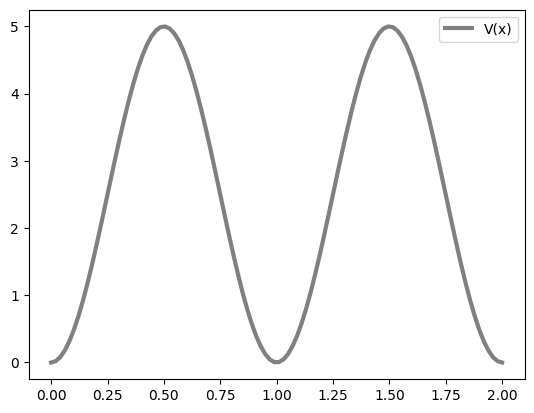

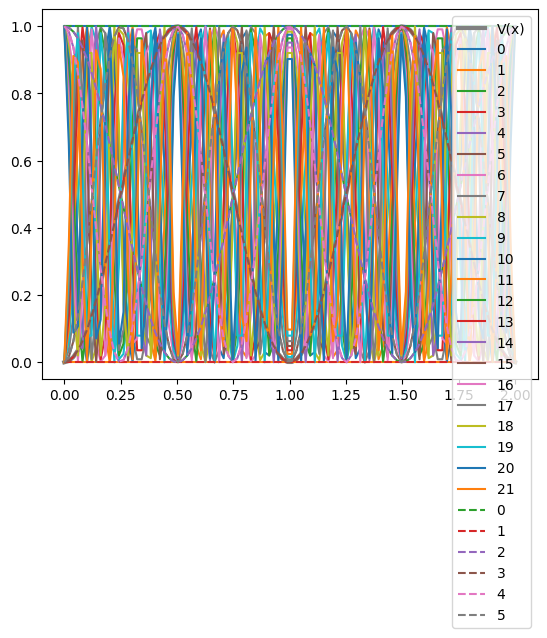

In [117]:
x = np.linspace(0, L, 100)

ypot = jax.vmap(pot_fn_single_particle)(x.reshape(-1, sdim))

plt.plot(x, ypot, label="V(x)", color='grey', lw=3)

plt.legend()
plt.show()

x = np.linspace(0, L, 100)
y1,y2 = wannier_basis_fn(x.reshape(-1, sdim), extent=hi.geometry.extent, m_max_L=m_max_L, m_max_a=m_max_a)

ypot = jax.vmap(pot_fn_single_particle)(x.reshape(-1, sdim))

plt.plot(x, ypot/V0, label="V(x)", color='grey', lw=3)
for m, ym in enumerate(y2.T):
    plt.plot(x, ym**2, label=f"{m}")
for m, ym in enumerate(y1.T):
    plt.plot(x, ym**2, label=f"{m}", linestyle="dashed")
plt.legend()
plt.show()

In [118]:
# burn in before optimizing
for i in range(20):
    print(i)
    vs.samples
    vs.reset()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [119]:
x_ex = np.linspace(0, L, Ngrid, endpoint=False)
eigenvalues, eigenvectors = diagonalize_Ham_jax(L, V0, x_ex)
print(f"exact E for V0={V0}:", np.min(eigenvalues), eigenvalues[0])

opt = nk.optimizer.Sgd(0.01)
sr = nk.optimizer.SR(diag_shift=0.0001)

log = nk.logging.JsonLog("runs/test")

def mycb(step, log_data, driver):
    log_data["sampler_scale"] = float(vs.sampler_state.rule_state)
    return True

gs = nk.VMC(ham, opt, variational_state=vs, preconditioner=sr)
gs.run(n_iter=500, callback=mycb, out=log)

exact E for V0=5.0: 1.422528045872321 1.422528045872321


  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

dict_keys(['acceptance', 'Energy', 'sampler_scale'])


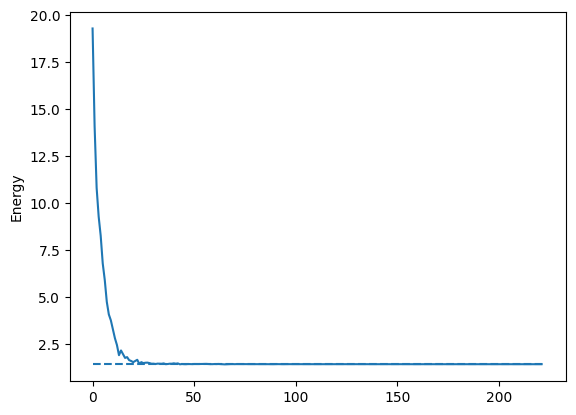

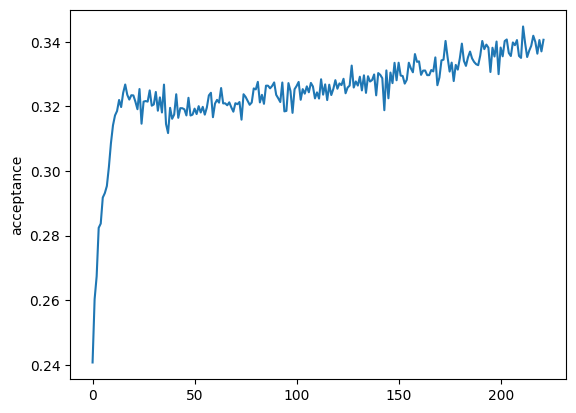

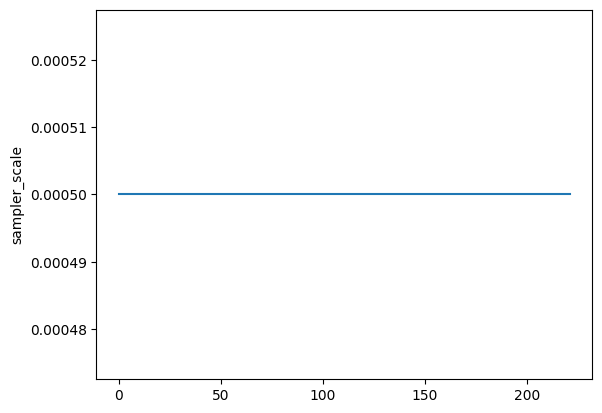

In [120]:

import json

with open("runs/test.log", 'r') as f:
    data = json.load(f)
print(data.keys())

plt.plot(data["Energy"]["iters"], data["Energy"]["Mean"]["real"])
plt.hlines(eigenvalues[0], 0, len(data["Energy"]["iters"]), linestyles='dashed')
plt.ylabel("Energy")
plt.show()

plt.plot(data["acceptance"]["iters"], data["acceptance"]["value"])
plt.ylabel("acceptance")
plt.show()

plt.plot(data["sampler_scale"]["iters"], data["sampler_scale"]["value"])
plt.ylabel("sampler_scale")
plt.show()

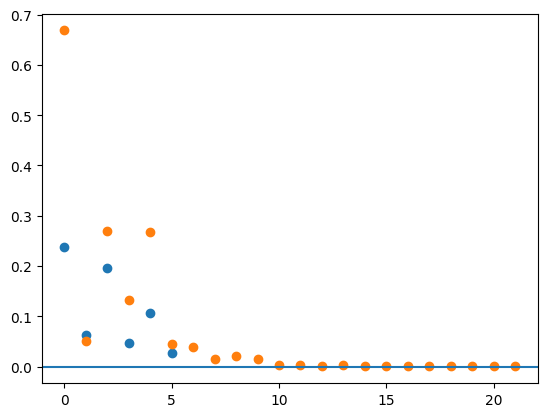

In [121]:
plt.scatter(np.arange(vs.parameters["cs1"].shape[1]), np.abs(vs.parameters["cs1"]))
plt.scatter(np.arange(vs.parameters["cs2"].shape[1]), np.abs(vs.parameters["cs2"]))
plt.axhline(0)
plt.show()

(100, 6) 28 [[ 0.23842483  0.06210437 -0.19519169  0.04648433  0.10544257 -0.02712044]]
(6,)


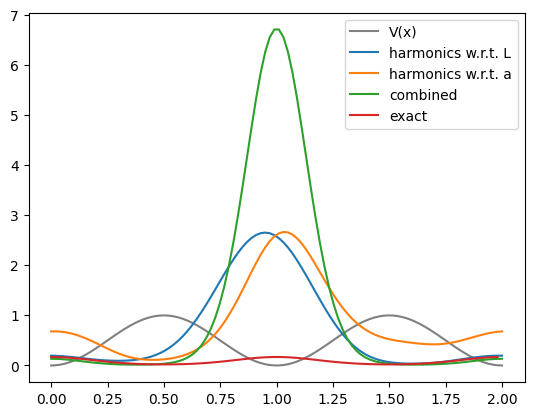

In [122]:
nbins = 100

x = np.linspace(0, L, nbins).reshape(-1, sdim)
ypot = jax.vmap(pot_fn_single_particle)(x)
plt.plot(x, ypot/V0, label="V(x)", color='grey')
y1,y2 = wannier_basis_fn(x, extent=hi.geometry.extent, m_max_L=model.m_wann_max_L, m_max_a=model.m_wann_max_a)
print(y1.shape, vs.n_parameters,vs.parameters["cs1"])

for cs in vs.parameters["cs1"]:
    cs /= jnp.linalg.norm(cs)
    print(cs.shape)
    ys1 = y1 @ cs
    plt.plot(x, ys1**2, label="harmonics w.r.t. L")

for cs in vs.parameters["cs2"]:
    cs /= jnp.linalg.norm(cs)
    ys2 = y2 @ cs
    plt.plot(x, ys2**2, label="harmonics w.r.t. a")
plt.plot(x, (ys2*ys1)**2, label="combined")

plt.plot(x_ex,eigenvectors[:,0], label="exact")

plt.legend()
plt.show()

Compute observables

In [81]:
nbins =200
import matplotlib.pyplot as plt
sam = vs.sample(chain_length=1024*3)

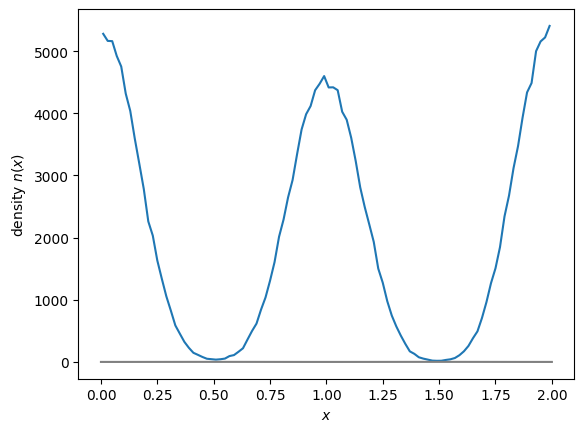

NameError: name 'N' is not defined

In [82]:
samples = sam.reshape(-1)
density, bin_edges = np.histogram(samples, bins=nbins//2, range=(0, L))
x = (bin_edges[1:] + bin_edges[:-1])/2
plt.plot(x,density)
plt.ylabel("density $n(x)$")
plt.xlabel("$x$")
xpot = np.linspace(0, L, 100).reshape(-1, sdim)
plt.plot(xpot, ypot/V0, label="V(x)", color='grey')
plt.show()


samples = sam.reshape(-1,N)
density_up, bin_edges = np.histogram(samples[:,:n_per_spin[0]], bins=nbins//2, range=(0, L))
density_dn, bin_edges = np.histogram(samples[:,n_per_spin[0]:], bins=nbins//2, range=(0, L))
x = (bin_edges[1:] + bin_edges[:-1])/2
plt.plot(x,(density_up-density_dn))
plt.ylabel("magnetization $m(x)$")
plt.xlabel("$x$")